In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

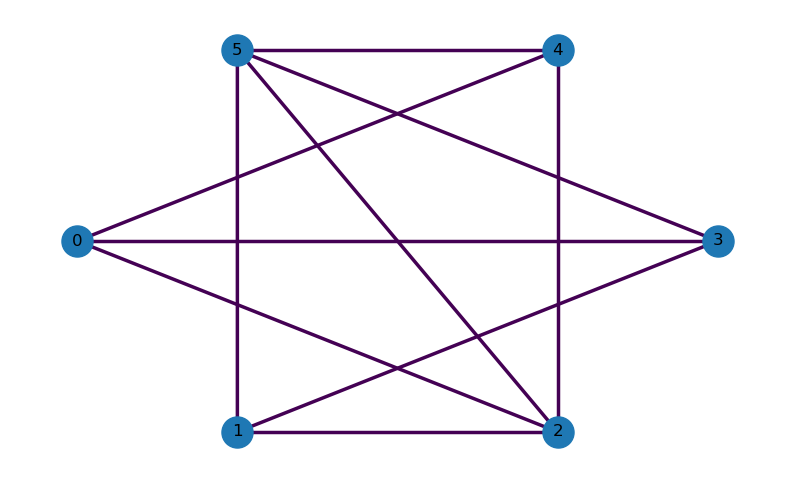

In [3]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [4]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem.
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

/opt/anaconda3/envs/flowenv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [7]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

In [8]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


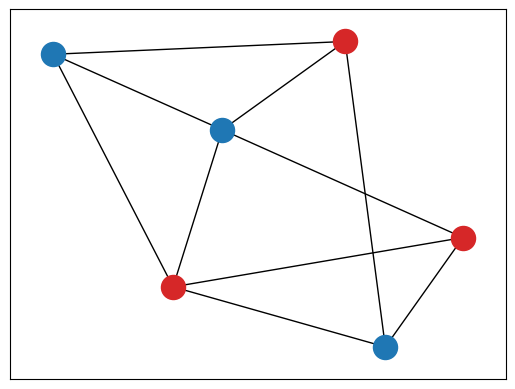

In [9]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

In [10]:
# initialize model with default configurations
q = QAOA()

In [11]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [12]:
q.compile(maxcut_qubo)

In [13]:
q.optimize()

In [14]:
opt_results = q.result

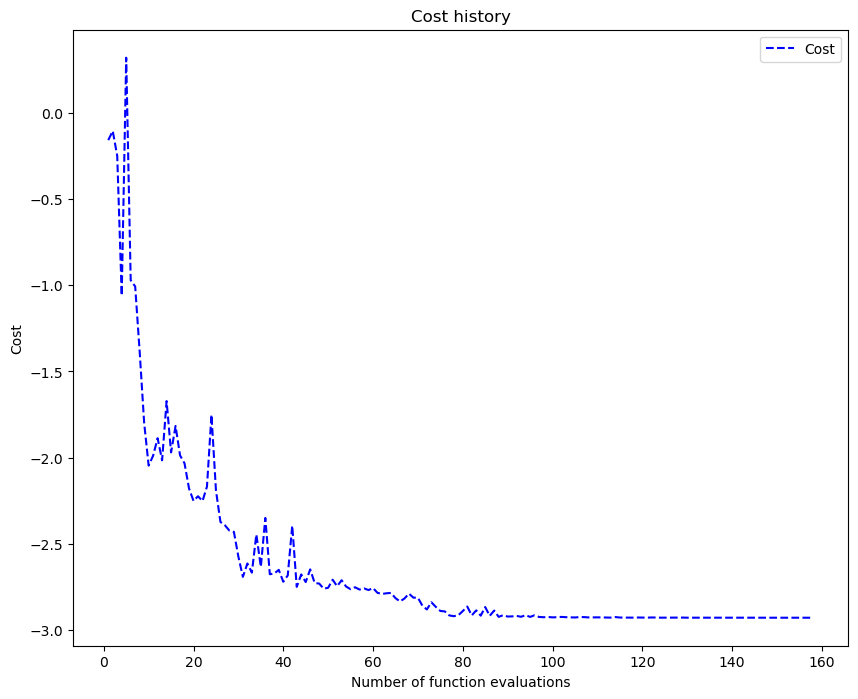

In [15]:
# print the cost history
fig, ax = opt_results.plot_cost()

In [16]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [17]:
pprint(opt_results.optimized)

{'angles': [0.334208590447, 0.162236336418, 3.384764508344, 1.169470117854],
 'cost': -2.92661707383,
 'eval_number': 149,
 'job_id': '63007ce0-50cd-4a0a-833a-5cee4def11fc',
 'measurement_outcomes': array([-0.00202017-0.00158702j,  0.03568494-0.00288594j,
        0.03992697-0.0406237j , -0.02982872-0.11903726j,
       -0.00137261+0.02911856j,  0.02007021+0.09187751j,
        0.02237362+0.05542671j, -0.11145075-0.16701401j,
        0.03568494-0.00288594j,  0.04494713-0.04350448j,
        0.02117557+0.01487429j,  0.0195043 +0.11253449j,
        0.14862093+0.07911417j, -0.11312667-0.11650081j,
       -0.13267239-0.07543539j,  0.02237362+0.05542671j,
        0.03992697-0.0406237j ,  0.02117557+0.01487429j,
       -0.00394371-0.07650543j,  0.21095602+0.11053102j,
        0.00080527+0.01814677j,  0.00302224-0.07113533j,
       -0.11312667-0.11650081j,  0.02007021+0.09187751j,
       -0.02982872-0.11903726j,  0.0195043 +0.11253449j,
        0.21095602+0.11053102j, -0.13627929-0.06422549j,
   

In [18]:
variational_params = q.optimizer.variational_params

In [19]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                    ┌──────────────┐»
q1_0: ┤ H ├─■────────────■─────────────────────────■───────────┤ Rx(-0.66842) ├»
      ├───┤ │            │                         │           └──────────────┘»
q1_1: ┤ H ├─┼────────────┼────────────■────────────┼─────────────■─────────────»
      ├───┤ │ZZ(6.7695)  │            │ZZ(6.7695)  │             │             »
q1_2: ┤ H ├─■────────────┼────────────■────────────┼─────────────┼─────────────»
      ├───┤              │ZZ(6.7695)               │             │ZZ(6.7695)   »
q1_3: ┤ H ├──────────────■─────────────────────────┼─────────────■─────────────»
      ├───┤                                        │ZZ(6.7695)                 »
q1_4: ┤ H ├────────────────────────────────────────■───────────────────────────»
      ├───┤                                                                    »
q1_5: ┤ H ├────────────────────────────────────────────────────────────────────»
      └───┘                                                                    »
«                                                                »
«q1_0: ──────────────────────────────────────────────────────────»
«                   ┌──────────────┐                             »
«q1_1: ─■───────────┤ Rx(-0.66842) ├─────────────────────────────»
«       │           └──────────────┘             ┌──────────────┐»
«q1_2: ─┼─────────────■──────────────■───────────┤ Rx(-0.66842) ├»
«       │             │              │           └──────────────┘»
«q1_3: ─┼─────────────┼──────────────┼─────────────■─────────────»
«       │             │ZZ(6.7695)    │             │             »
«q1_4: ─┼─────────────■──────────────┼─────────────┼─────────────»
«       │ZZ(6.7695)                  │ZZ(6.7695)   │ZZ(6.7695)   »
«q1_5: ─■────────────────────────────■─────────────■─────────────»
«                                                                »
«                                                                »
«q1_0: ──■───────────────■───────────────────────────■───────────»
«        │               │                           │           »
«q1_1: ──┼───────────────┼──────────────■────────────┼───────────»
«        │ZZ(2.3389)     │              │ZZ(2.3389)  │           »
«q1_2: ──■───────────────┼──────────────■────────────┼───────────»
«      ┌──────────────┐  │ZZ(2.3389)                 │           »
«q1_3: ┤ Rx(-0.66842) ├──■───────────────────────────┼───────────»
«      └──────────────┘┌──────────────┐              │ZZ(2.3389) »
«q1_4: ──■─────────────┤ Rx(-0.66842) ├──────────────■───────────»
«        │ZZ(6.7695)   ├──────────────┤                          »
«q1_5: ──■─────────────┤ Rx(-0.66842) ├──────────────────────────»
«                      └──────────────┘                          »
«      ┌──────────────┐                                          »
«q1_0: ┤ Rx(-0.32447) ├──────────────────────────────────────────»
«      └──────────────┘             ┌──────────────┐             »
«q1_1: ──■──────────────■───────────┤ Rx(-0.32447) ├─────────────»
«        │              │           └──────────────┘             »
«q1_2: ──┼──────────────┼─────────────■──────────────■───────────»
«        │ZZ(2.3389)    │             │              │           »
«q1_3: ──■──────────────┼─────────────┼──────────────┼───────────»
«                       │             │ZZ(2.3389)    │           »
«q1_4: ─────────────────┼─────────────■──────────────┼───────────»
«                       │ZZ(2.3389)                  │ZZ(2.3389) »
«q1_5: ─────────────────■────────────────────────────■───────────»
«                                                                »
«                                                      
«q1_0: ────────────────────────────────────────────────
«                                                      
«q1_1: ────────────────────────────────────────────────
«      ┌──────────────┐                                
«q1_2: ┤ Rx(-0.32447) ├────────────────────────────────
«   